In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.modeling import models, fitting
from stingray import Lightcurve

#load the summary characteristic files
profile_df = pd.read_csv('eruption_profiles.csv')
dc_df = pd.read_csv('eruption_dcs.csv')

In [2]:
display(profile_df)

,Seg,Amplitude,Duration
0,0124710801_e1.lc,7.735395,1299.881253
1,0411980401_e1.lc,1.099665,710.572857
2,0823680101_e1.lc,5.663419,1925.302234
3,0823680101_e2.lc,7.598665,2066.117327
4,0831790701_e1.lc,6.000399,2047.941361
...,...,...,...
64,0914792901_e2.lc,1.894667,2028.815246
65,0914792901_e3.lc,1.496194,1367.898424
66,0914792901_e4.lc,2.103191,2117.715862
67,0914793101_e1.lc,3.839753,2154.157649


In [3]:
display(dc_df)

,Obs,DC
0,823680101,0.062658
1,831790701,0.063465
2,851180401,0.070647
3,851180501,0.095459
4,864330101,0.074272
5,864560101,0.080186
6,872390101,0.216805
7,893810501,0.082504
8,883770201,0.101403
9,904640201,0.071230


(array([ 9.,  3.,  6., 11., 11., 12.,  6.,  0.,  3.,  3.,  1.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]),
 <BarContainer object of 29 artists>)

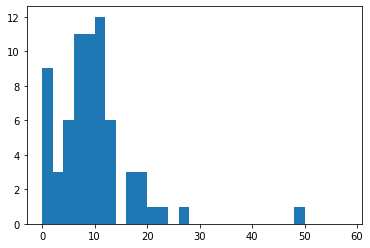

In [5]:
#profile the feature distributions for the simulated lc generator
plt.hist(profile_df['Amplitude'],bins=np.arange(0,60,2))

(array([ 0.,  0.,  0., 12.,  7.,  3., 13., 10.,  3.,  6., 12.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
        2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200,
        4400, 4600, 4800]),
 <BarContainer object of 24 artists>)

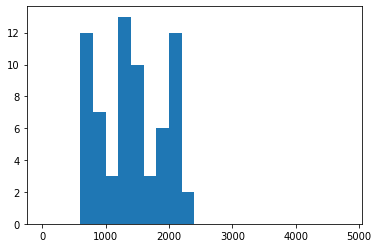

In [11]:
plt.hist(profile_df['Duration'],bins=np.arange(0,5000,200))

(array([1., 3., 7., 2., 0., 0., 0., 0., 0., 1.]),
 array([0.03147005, 0.05000358, 0.06853712, 0.08707065, 0.10560418,
        0.12413771, 0.14267124, 0.16120477, 0.1797383 , 0.19827183,
        0.21680537]),
 <BarContainer object of 10 artists>)

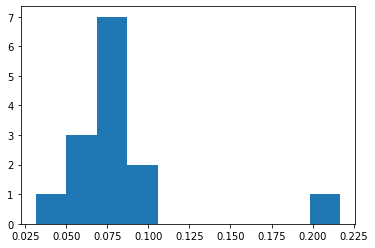

In [12]:
plt.hist(dc_df['DC'])

In [ ]:
#load data file(s) for observations with new detected QPEs to add to summary csv
hdul1 = fits.open('/home/rwebbe/astro_data/QPE_profiling/P0883770201PNX000SRCTSR8002.FTZ')
hdul2 = fits.open('/home/rwebbe/astro_data/QPE_profiling/P0904640201PNX000SRCTSR8001.FTZ')
hdul3 = fits.open('/home/rwebbe/astro_data/QPE_profiling/P0904640301PNX000SRCTSR8002.FTZ')
hdul4 = fits.open('/home/rwebbe/astro_data/QPE_profiling/P0913990201PNX000SRCTSR8001.FTZ')
hdul5 = fits.open('/home/rwebbe/astro_data/QPE_profiling/P0914792901PNX000SRCTSR8001.FTZ')
hdul6 = fits.open('/home/rwebbe/astro_data/QPE_profiling/P0914793101PNX000SRCTSR8001.FTZ')


In [ ]:
all_new_amps = []
all_new_durs = []
all_new_poss = [[],[],[],[],[],[]]

In [ ]:
#for each new eruption, profile, and add the details to the df
time = hdul1[1].data.field('TIME')
rate1 = hdul1[1].data.field('RATE1')
rate2 = hdul1[1].data.field('RATE2')
rate3 = hdul1[1].data.field('RATE3')
rate = rate1 + rate2 + rate3
gtis = []
for i in hdul1[2].data:
    gtis.append([i[0],i[1]])
lc = Lightcurve(time[np.isfinite(rate)],rate[np.isfinite(rate)],gti=gtis,input_counts=False)
lc.apply_gtis()
lc = lc.rebin(50)
lc = lc.shift(-lc.time[0])
lc.plot()


In [ ]:
lc_segs = []
lc_segs.append(lc.truncate(5000,12000,method='time'))
lc_segs.append(lc.truncate(12000,20000,method='time'))
lc_segs.append(lc.truncate(20000,30000,method='time'))
lc_segs.append(lc.truncate(30000,38000,method='time'))
lc_segs.append(lc.truncate(38000,45000,method='time'))
lc_segs.append(lc.truncate(45000,52000,method='time'))
for seg in lc_segs:
    seg.plot()

In [ ]:
model1 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=8500,stddev=2500)
fit1 = fitting.LevMarLSQFitter()
eruption1 = fit1(model1,lc_segs[0].time,lc_segs[0].counts)
plt.scatter(lc_segs[0].time,lc_segs[0].counts)
plt.plot(lc_segs[0].time,eruption1(lc_segs[0].time))
all_new_amps.append(eruption1.parameters[1]/eruption1.parameters[0])
all_new_poss[0].append((eruption1.parameters[2]))
all_new_durs.append(eruption1.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model2 = models.Const1D(1) + models.Gaussian1D(amplitude=15,mean=16500,stddev=2500)
fit2 = fitting.LevMarLSQFitter()
eruption2 = fit2(model2,lc_segs[1].time,lc_segs[1].counts)
plt.scatter(lc_segs[1].time,lc_segs[1].counts)
plt.plot(lc_segs[1].time,eruption2(lc_segs[1].time))
all_new_amps.append(eruption2.parameters[1]/eruption2.parameters[0])
all_new_poss[0].append((eruption2.parameters[2]))
all_new_durs.append(eruption2.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model3 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=25000,stddev=2500)
fit3 = fitting.LevMarLSQFitter()
eruption3 = fit3(model3,lc_segs[2].time,lc_segs[2].counts)
plt.scatter(lc_segs[2].time,lc_segs[2].counts)
plt.plot(lc_segs[2].time,eruption3(lc_segs[2].time))
all_new_amps.append(eruption3.parameters[1]/eruption3.parameters[0])
all_new_poss[0].append((eruption3.parameters[2]))
all_new_durs.append(eruption3.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model4 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=33000,stddev=2500)
fit4 = fitting.LevMarLSQFitter()
eruption4 = fit4(model4,lc_segs[3].time,lc_segs[3].counts)
plt.scatter(lc_segs[3].time,lc_segs[3].counts)
plt.plot(lc_segs[3].time,eruption4(lc_segs[3].time))
all_new_amps.append(eruption4.parameters[1]/eruption4.parameters[0])
all_new_poss[0].append((eruption4.parameters[2]))
all_new_durs.append(eruption4.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model5 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=41500,stddev=2500)
fit5 = fitting.LevMarLSQFitter()
eruption5 = fit5(model5,lc_segs[4].time,lc_segs[4].counts)
plt.scatter(lc_segs[4].time,lc_segs[4].counts)
plt.plot(lc_segs[4].time,eruption5(lc_segs[4].time))
all_new_amps.append(eruption5.parameters[1]/eruption5.parameters[0])
all_new_poss[0].append((eruption5.parameters[2]))
all_new_durs.append(eruption5.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model6 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=49000,stddev=2500)
fit6 = fitting.LevMarLSQFitter()
eruption6 = fit6(model6,lc_segs[5].time,lc_segs[5].counts)
plt.scatter(lc_segs[5].time,lc_segs[5].counts)
plt.plot(lc_segs[5].time,eruption6(lc_segs[5].time))
all_new_amps.append(eruption6.parameters[1]/eruption6.parameters[0])
all_new_poss[0].append((eruption6.parameters[2]))
all_new_durs.append(eruption6.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
#for each new eruption, profile, and add the details to the df
time = hdul2[1].data.field('TIME')
rate1 = hdul2[1].data.field('RATE1')
rate2 = hdul2[1].data.field('RATE2')
rate3 = hdul2[1].data.field('RATE3')
rate = rate1 + rate2 + rate3
gtis = []
for i in hdul2[2].data:
    gtis.append([i[0],i[1]])
lc = Lightcurve(time[np.isfinite(rate)],rate[np.isfinite(rate)],gti=gtis,input_counts=False)
lc.apply_gtis()
lc = lc.rebin(50)
lc = lc.shift(-lc.time[0])
lc.plot()


In [ ]:
lc_segs = []
lc_segs.append(lc.truncate(0,20000,method='time'))
lc_segs.append(lc.truncate(20000,40000,method='time'))
lc_segs.append(lc.truncate(40000,60000,method='time'))
lc_segs.append(lc.truncate(60000,80000,method='time'))
lc_segs.append(lc.truncate(80000,98000,method='time'))
lc_segs.append(lc.truncate(98000,110000,method='time'))
for seg in lc_segs:
    seg.plot()

In [ ]:
model1 = models.Const1D(0) + models.Gaussian1D(amplitude=30,mean=3000,stddev=1000)
fit1 = fitting.LevMarLSQFitter()
eruption1 = fit1(model1,lc_segs[0].time,lc_segs[0].counts)
plt.scatter(lc_segs[0].time,lc_segs[0].counts)
plt.plot(lc_segs[0].time,eruption1(lc_segs[0].time))
all_new_amps.append(eruption1.parameters[1]/eruption1.parameters[0])
all_new_poss[1].append((eruption1.parameters[2]))
all_new_durs.append(eruption1.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model2 = models.Const1D(1) + models.Gaussian1D(amplitude=35,mean=27000,stddev=500)
fit2 = fitting.LevMarLSQFitter()
eruption2 = fit2(model2,lc_segs[1].time,lc_segs[1].counts)
plt.scatter(lc_segs[1].time,lc_segs[1].counts)
plt.plot(lc_segs[1].time,eruption2(lc_segs[1].time))
all_new_amps.append(eruption2.parameters[1]/eruption2.parameters[0])
all_new_poss[1].append((eruption2.parameters[2]))
all_new_durs.append(eruption2.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model3 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=48500,stddev=500)
fit3 = fitting.LevMarLSQFitter()
eruption3 = fit3(model3,lc_segs[2].time,lc_segs[2].counts)
plt.scatter(lc_segs[2].time,lc_segs[2].counts)
plt.plot(lc_segs[2].time,eruption3(lc_segs[2].time))
all_new_amps.append(eruption3.parameters[1]/eruption3.parameters[0])
all_new_poss[1].append((eruption3.parameters[2]))
all_new_durs.append(eruption3.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model4 = models.Const1D(0) + models.Gaussian1D(amplitude=35,mean=71000,stddev=2500)
fit4 = fitting.LevMarLSQFitter()
eruption4 = fit4(model4,lc_segs[3].time,lc_segs[3].counts)
plt.scatter(lc_segs[3].time,lc_segs[3].counts)
plt.plot(lc_segs[3].time,eruption4(lc_segs[3].time))
all_new_amps.append(eruption4.parameters[1]/eruption4.parameters[0])
all_new_poss[1].append((eruption4.parameters[2]))
all_new_durs.append(eruption4.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model5 = models.Const1D(0) + models.Gaussian1D(amplitude=20,mean=93000,stddev=2500)
fit5 = fitting.LevMarLSQFitter()
eruption5 = fit5(model5,lc_segs[4].time,lc_segs[4].counts)
plt.scatter(lc_segs[4].time,lc_segs[4].counts)
plt.plot(lc_segs[4].time,eruption5(lc_segs[4].time))
all_new_amps.append(eruption5.parameters[1]/eruption5.parameters[0])
all_new_poss[1].append((eruption5.parameters[2]))
all_new_durs.append(eruption5.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model6 = models.Const1D(0) + models.Gaussian1D(amplitude=35,mean=103000,stddev=500)
fit6 = fitting.LevMarLSQFitter()
eruption6 = fit6(model6,lc_segs[5].time,lc_segs[5].counts)
plt.scatter(lc_segs[5].time,lc_segs[5].counts)
plt.plot(lc_segs[5].time,eruption6(lc_segs[5].time))
all_new_amps.append(eruption6.parameters[1]/eruption6.parameters[0])
all_new_poss[1].append((eruption6.parameters[2]))
all_new_durs.append(eruption6.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
#for each new eruption, profile, and add the details to the df
time = hdul3[1].data.field('TIME')
rate1 = hdul3[1].data.field('RATE1')
rate2 = hdul3[1].data.field('RATE2')
rate3 = hdul3[1].data.field('RATE3')
rate = rate1 + rate2 + rate3
gtis = []
for i in hdul3[2].data:
    gtis.append([i[0],i[1]])
lc = Lightcurve(time[np.isfinite(rate)],rate[np.isfinite(rate)],gti=gtis,input_counts=False)
lc.apply_gtis()
lc = lc.rebin(50)
lc = lc.shift(-lc.time[0])
lc.plot()


In [ ]:
lc_segs = []
lc_segs.append(lc.truncate(20000,40000,method='time'))
lc_segs.append(lc.truncate(40000,58000,method='time'))
lc_segs.append(lc.truncate(58000,78000,method='time'))
lc_segs.append(lc.truncate(78000,90000,method='time'))
lc_segs.append(lc.truncate(90000,105000,method='time'))
lc_segs.append(lc.truncate(105000,method='time'))
for seg in lc_segs:
    seg.plot()

In [ ]:
model1 = models.Const1D(0) + models.Gaussian1D(amplitude=60,mean=25000,stddev=1000)
fit1 = fitting.LevMarLSQFitter()
eruption1 = fit1(model1,lc_segs[0].time,lc_segs[0].counts)
plt.scatter(lc_segs[0].time,lc_segs[0].counts)
plt.plot(lc_segs[0].time,eruption1(lc_segs[0].time))
all_new_amps.append(eruption1.parameters[1]/eruption1.parameters[0])
all_new_poss[2].append((eruption1.parameters[2]))
all_new_durs.append(eruption1.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model2 = models.Const1D(1) + models.Gaussian1D(amplitude=60,mean=47000,stddev=500)
fit2 = fitting.LevMarLSQFitter()
eruption2 = fit2(model2,lc_segs[1].time,lc_segs[1].counts)
plt.scatter(lc_segs[1].time,lc_segs[1].counts)
plt.plot(lc_segs[1].time,eruption2(lc_segs[1].time))
all_new_amps.append(eruption2.parameters[1]/eruption2.parameters[0])
all_new_poss[2].append((eruption2.parameters[2]))
all_new_durs.append(eruption2.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model3 = models.Const1D(0) + models.Gaussian1D(amplitude=70,mean=63000,stddev=500)
fit3 = fitting.LevMarLSQFitter()
eruption3 = fit3(model3,lc_segs[2].time,lc_segs[2].counts)
plt.scatter(lc_segs[2].time,lc_segs[2].counts)
plt.plot(lc_segs[2].time,eruption3(lc_segs[2].time))
all_new_amps.append(eruption3.parameters[1]/eruption3.parameters[0])
all_new_poss[2].append((eruption3.parameters[2]))
all_new_durs.append(eruption3.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model4 = models.Const1D(0) + models.Gaussian1D(amplitude=60,mean=84000,stddev=2500)
fit4 = fitting.LevMarLSQFitter()
eruption4 = fit4(model4,lc_segs[3].time,lc_segs[3].counts)
plt.scatter(lc_segs[3].time,lc_segs[3].counts)
plt.plot(lc_segs[3].time,eruption4(lc_segs[3].time))
all_new_amps.append(eruption4.parameters[1]/eruption4.parameters[0])
all_new_poss[2].append((eruption4.parameters[2]))
all_new_durs.append(eruption4.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model5 = models.Const1D(0) + models.Gaussian1D(amplitude=60,mean=96500,stddev=2500)
fit5 = fitting.LevMarLSQFitter()
eruption5 = fit5(model5,lc_segs[4].time,lc_segs[4].counts)
plt.scatter(lc_segs[4].time,lc_segs[4].counts)
plt.plot(lc_segs[4].time,eruption5(lc_segs[4].time))
all_new_amps.append(eruption5.parameters[1]/eruption5.parameters[0])
all_new_poss[2].append((eruption5.parameters[2]))
all_new_durs.append(eruption5.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model6 = models.Const1D(0) + models.Gaussian1D(amplitude=70,mean=114500,stddev=500)
fit6 = fitting.LevMarLSQFitter()
eruption6 = fit6(model6,lc_segs[5].time,lc_segs[5].counts)
plt.scatter(lc_segs[5].time,lc_segs[5].counts)
plt.plot(lc_segs[5].time,eruption6(lc_segs[5].time))
all_new_amps.append(eruption6.parameters[1]/eruption6.parameters[0])
all_new_poss[2].append((eruption6.parameters[2]))
all_new_durs.append(eruption6.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
#for each new eruption, profile, and add the details to the df
time = hdul4[1].data.field('TIME')
rate1 = hdul4[1].data.field('RATE1')
rate2 = hdul4[1].data.field('RATE2')
rate3 = hdul4[1].data.field('RATE3')
rate = rate1 + rate2 + rate3
gtis = []
for i in hdul4[2].data:
    gtis.append([i[0],i[1]])
lc = Lightcurve(time[np.isfinite(rate)],rate[np.isfinite(rate)],gti=gtis,input_counts=False)
lc.apply_gtis()
lc = lc.rebin(50)
lc = lc.shift(-lc.time[0])
lc.plot()


In [ ]:
lc_segs = []
lc_segs.append(lc.truncate(20000,30000,method='time'))
lc_segs.append(lc.truncate(40000,55000,method='time'))
for seg in lc_segs:
    seg.plot()

In [ ]:
model1 = models.Const1D(10) + models.Gaussian1D(amplitude=35,mean=25500,stddev=1000)
fit1 = fitting.LevMarLSQFitter()
eruption1 = fit1(model1,lc_segs[0].time,lc_segs[0].counts)
plt.scatter(lc_segs[0].time,lc_segs[0].counts)
plt.plot(lc_segs[0].time,eruption1(lc_segs[0].time))
all_new_amps.append(eruption1.parameters[1]/eruption1.parameters[0])
all_new_poss[3].append((eruption1.parameters[2]))
all_new_durs.append(eruption1.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model2 = models.Const1D(20) + models.Gaussian1D(amplitude=100,mean=45000,stddev=500)
fit2 = fitting.LevMarLSQFitter()
eruption2 = fit2(model2,lc_segs[1].time,lc_segs[1].counts)
plt.scatter(lc_segs[1].time,lc_segs[1].counts)
plt.plot(lc_segs[1].time,eruption2(lc_segs[1].time))
all_new_amps.append(eruption2.parameters[1]/eruption2.parameters[0])
all_new_poss[3].append((eruption2.parameters[2]))
all_new_durs.append(eruption2.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
#for each new eruption, profile, and add the details to the df
time = hdul5[1].data.field('TIME')
rate1 = hdul5[1].data.field('RATE1')
rate2 = hdul5[1].data.field('RATE2')
rate3 = hdul5[1].data.field('RATE3')
rate = rate1 + rate2 + rate3
gtis = []
for i in hdul5[2].data:
    gtis.append([i[0],i[1]])
lc = Lightcurve(time[np.isfinite(rate)],rate[np.isfinite(rate)],gti=gtis,input_counts=False)
lc.apply_gtis()
lc = lc.rebin(50)
lc = lc.shift(-lc.time[0])
lc.plot()


In [ ]:
lc_segs = []
lc_segs.append(lc.truncate(0,20000,method='time'))
lc_segs.append(lc.truncate(20000,50000,method='time'))
lc_segs.append(lc.truncate(50000,80000,method='time'))
lc_segs.append(lc.truncate(80000,110000,method='time'))
for seg in lc_segs:
    seg.plot()

In [ ]:
model1 = models.Const1D(10) + models.Gaussian1D(amplitude=35,mean=9000,stddev=1000)
fit1 = fitting.LevMarLSQFitter()
eruption1 = fit1(model1,lc_segs[0].time,lc_segs[0].counts)
plt.scatter(lc_segs[0].time,lc_segs[0].counts)
plt.plot(lc_segs[0].time,eruption1(lc_segs[0].time))
all_new_amps.append(eruption1.parameters[1]/eruption1.parameters[0])
all_new_poss[4].append((eruption1.parameters[2]))
all_new_durs.append(eruption1.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model2 = models.Const1D(20) + models.Gaussian1D(amplitude=60,mean=36000,stddev=500)
fit2 = fitting.LevMarLSQFitter()
eruption2 = fit2(model2,lc_segs[1].time,lc_segs[1].counts)
plt.scatter(lc_segs[1].time,lc_segs[1].counts)
plt.plot(lc_segs[1].time,eruption2(lc_segs[1].time))
all_new_amps.append(eruption2.parameters[1]/eruption2.parameters[0])
all_new_poss[4].append((eruption2.parameters[2]))
all_new_durs.append(eruption2.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model3 = models.Const1D(20) + models.Gaussian1D(amplitude=60,mean=69000,stddev=500)
fit3 = fitting.LevMarLSQFitter()
eruption3 = fit3(model3,lc_segs[2].time,lc_segs[2].counts)
plt.scatter(lc_segs[2].time,lc_segs[2].counts)
plt.plot(lc_segs[2].time,eruption3(lc_segs[2].time))
all_new_amps.append(eruption3.parameters[1]/eruption3.parameters[0])
all_new_poss[4].append((eruption4.parameters[2]))
all_new_durs.append(eruption3.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model4 = models.Const1D(20) + models.Gaussian1D(amplitude=50,mean=96500,stddev=2500)
fit4 = fitting.LevMarLSQFitter()
eruption4 = fit4(model4,lc_segs[3].time,lc_segs[3].counts)
plt.scatter(lc_segs[3].time,lc_segs[3].counts)
plt.plot(lc_segs[3].time,eruption4(lc_segs[3].time))
all_new_amps.append(eruption4.parameters[1]/eruption4.parameters[0])
all_new_poss[4].append((eruption4.parameters[2]))
all_new_durs.append(eruption4.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
#for each new eruption, profile, and add the details to the df
time = hdul6[1].data.field('TIME')
rate1 = hdul6[1].data.field('RATE1')
rate2 = hdul6[1].data.field('RATE2')
rate3 = hdul6[1].data.field('RATE3')
rate = rate1 + rate2 + rate3
gtis = []
for i in hdul6[2].data:
    gtis.append([i[0],i[1]])
lc = Lightcurve(time[np.isfinite(rate)],rate[np.isfinite(rate)],gti=gtis,input_counts=False)
lc.apply_gtis()
lc = lc.rebin(50)
lc = lc.shift(-lc.time[0])
lc.plot()


In [ ]:
lc_segs = []
lc_segs.append(lc.truncate(20000,40000,method='time'))
lc_segs.append(lc.truncate(80000,1000000,method='time'))
for seg in lc_segs:
    seg.plot()

In [ ]:
model1 = models.Const1D(20) + models.Gaussian1D(amplitude=60,mean=27000,stddev=1000)
fit1 = fitting.LevMarLSQFitter()
eruption1 = fit1(model1,lc_segs[0].time,lc_segs[0].counts)
plt.scatter(lc_segs[0].time,lc_segs[0].counts)
plt.plot(lc_segs[0].time,eruption1(lc_segs[0].time))
all_new_amps.append(eruption1.parameters[1]/eruption1.parameters[0])
all_new_poss[5].append((eruption1.parameters[2]))
all_new_durs.append(eruption1.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
model2 = models.Const1D(20) + models.Gaussian1D(amplitude=40,mean=90000,stddev=500)
fit2 = fitting.LevMarLSQFitter()
eruption2 = fit2(model2,lc_segs[1].time,lc_segs[1].counts)
plt.scatter(lc_segs[1].time,lc_segs[1].counts)
plt.plot(lc_segs[1].time,eruption2(lc_segs[1].time))
all_new_amps.append(eruption2.parameters[1]/eruption2.parameters[0])
all_new_poss[5].append((eruption2.parameters[2]))
all_new_durs.append(eruption2.parameters[3]*(2*np.sqrt(2*np.log(2))))

In [ ]:
#for each new observation with eruptions, add the eruption details to the profile df
new_eruption_df = pd.DataFrame(columns=['Seg','Amplitude','Duration'])
new_eruption_df['Seg'] = ['0883770201_e1.lc','0883770201_e2.lc','0883770201_e3.lc','0883770201_e4.lc','0883770201_e5.lc','0883770201_e6.lc',
                          '0904640201_e1.lc','0904640201_e2.lc','0904640201_e3.lc','0904640201_e4.lc','0904640201_e5.lc','0904640201_e6.lc',
                          '0904640301_e1.lc','0904640301_e2.lc','0904640301_e3.lc','0904640301_e4.lc','0904640301_e5.lc','0904640301_e6.lc',
                          '0913990201_e1.lc','0913990201_e2.lc','0914792901_e1.lc','0914792901_e2.lc','0914792901_e3.lc','0914792901_e4.lc',
                          '0914793101_e1.lc','0914793101_e2.lc']
new_eruption_df['Amplitude'] = all_new_amps
new_eruption_df['Duration'] = all_new_durs


In [ ]:
display(new_eruption_df)
new_eruption_df.shape

In [ ]:
full_profile_df = pd.concat([profile_df,new_eruption_df],ignore_index=True)
display(full_profile_df)

In [ ]:
#for each new observation with multiple eruptions, add the duty cycle info to the df
new_dc_df = pd.DataFrame(columns=['Obs','DC'])
new_dc_df['Obs'] = ['0883770201','0904640201','0904640301','0913990201','0914792901','0914793101']
new_obs_recs = [[],[],[],[],[],[]]
for i in range(6):
    for j in range(len(all_new_poss[i])-1):
        new_obs_recs[i].append(all_new_poss[i][j+1] - all_new_poss[i][j])
new_avg_recs = []
for i in new_obs_recs:
    new_avg_recs.append(np.average(i))
new_avg_recs = np.asarray(new_avg_recs)
avg_durs = np.asarray([np.average(all_new_durs[0:6]),np.average(all_new_durs[6:12]),np.average(all_new_durs[12:18]),np.average(all_new_durs[18:20]),np.average(all_new_durs[20:24]),np.average(all_new_durs[24:])])
new_dc_df['DC'] = avg_durs / new_avg_recs

display(new_dc_df)

In [ ]:
full_dc_df = pd.concat([dc_df,new_dc_df],ignore_index=True)
display(full_dc_df)

In [ ]:
#save the output files if desired
#full_profile_df.to_csv('eruption_profiles.csv',index=False)
#full_dc_df.to_csv('eruption_dcs.csv',index=False)